Building a model that classifies whether an individual survived the Titanic shipwreck or not. The target variable is the Survived column

In [125]:
#import libraries
import pyforest
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

##Preprocessing

In [126]:
#import data
df = pd.read_csv(r"C:\Users\Admin\Downloads\LuxDev\notes\ml\supervised\logistic regression(classification)\survived\titanic.csv", encoding="latin1")

df.head()

<IPython.core.display.Javascript object>

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [128]:
df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
886    False
887    False
888    False
889    False
890    False
Length: 891, dtype: bool

In [129]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

The dataset has considerable number of missing values in the age(177) and cabin(687) columns that should be filled to avoid affecting the model's accuracy.

Handle missing values

In [130]:
# check for skewness to determine how to handle missing values
numeric_columns =df.select_dtypes(include="number")
skewness = numeric_columns.skew()
skewness

PassengerId    0.000000
Survived       0.478523
Pclass        -0.630548
Age            0.389108
SibSp          3.695352
Parch          2.749117
Fare           4.787317
dtype: float64

from the above skewness insights:
the data is moderately skewed and the best way to impute missing values in such instances is using the median for the age, mode for categorical features (embarked).

We'll drop the cabin feature because its missing values are too many to impute without interfering with the dataset's accuracy

In [131]:
# handle missing values

# age
df["Age"].fillna(df["Age"].median(),inplace=True)

# embarked
df["Embarked"].fillna(df["Embarked"].mode()[0], inplace=True)

df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [132]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [133]:
#drop columns that cause model complexity(ID and Name) & errors(Cabin column due to high number of missing values)
df = df.drop(columns=["PassengerId", "Name", "Cabin", 'Ticket'])

# drop ticket column here because it has no significance on the target variable as seen in feature selection,
# and it has a high dimensionality after encoding to perform the feature importance step

##Exploratory Data Analysis

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

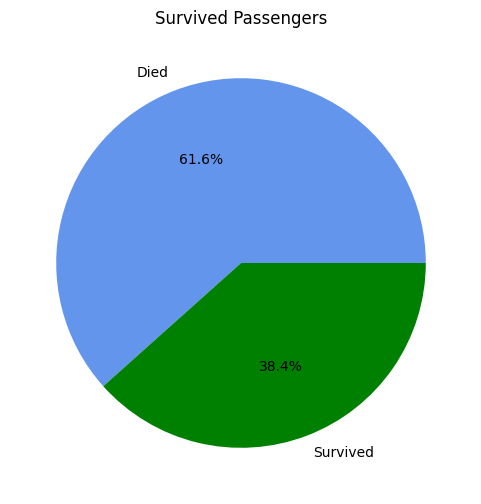

In [134]:
# visualize survived passengers
survived_counts = df['Survived'].value_counts()         #count the occurence of unique values
survived_counts

survived_labels = ["Died", "Survived"]                  #assign label variables for plot

#plot piechart showing gender proportion of survivors
fig, ax =plt.subplots(figsize=(6,6))

# add labels and title
ax.set_title('Survived Passengers')                     #add title
plt.pie(survived_counts, labels=survived_labels, colors=[
        'cornflowerblue', 'green'], autopct='%1.1f%%')  #autopct to add text values 
   
plt.show()                                              # Show plot


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

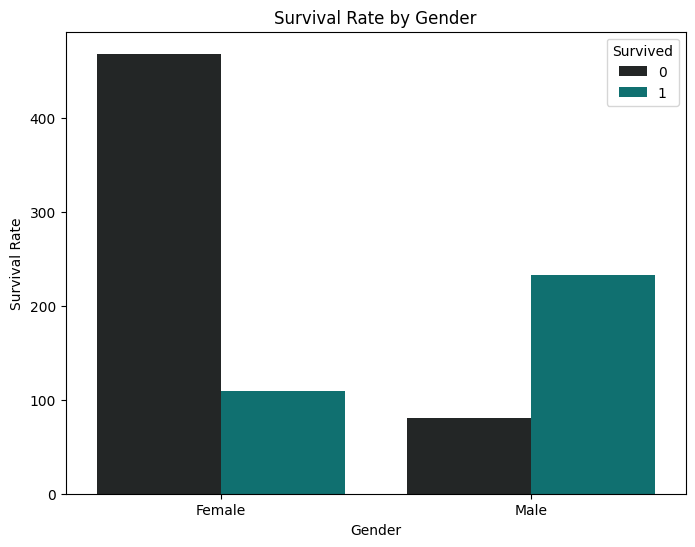

In [135]:
# Visualize survival by gender
plt.figure(figsize=(8, 6))
sns.countplot(x='Sex', hue='Survived', data=df, color="teal")  #hue adds a categorical dimension by coloring data points based on x variable

# adding labels and title
plt.xticks([0, 1], ['Female', 'Male'])                         #markers to denote a specific data points
plt.title('Survival Rate by Gender')
plt.ylabel('Survival Rate')
plt.xlabel('Gender')

plt.show()          # Show plot

In [136]:
# plot survived by fare(social class)

df.describe()       # to get fare ranges using percentiles

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

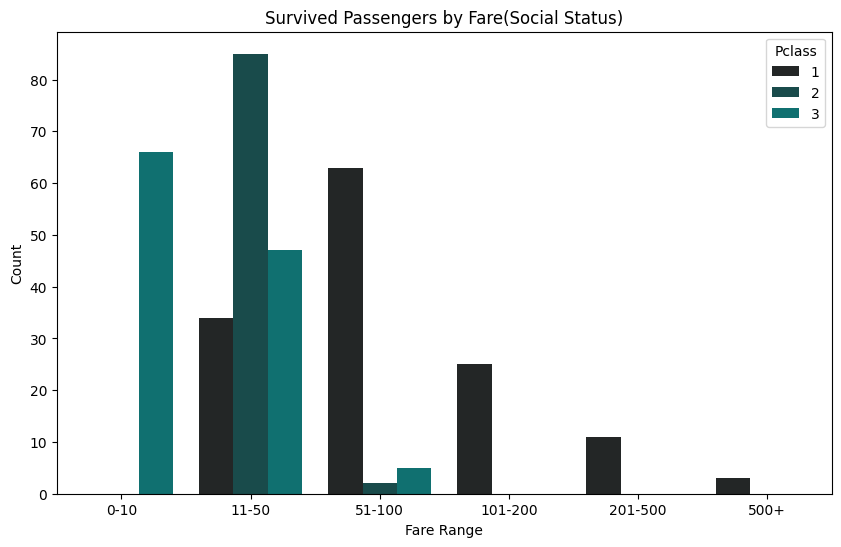

In [137]:
# Filter to get survived passengers only
survived_passengers = df[df['Survived'] == 1] 

# Define bins for different fare ranges
fare_bins = [0, 10, 50, 100, 200, 500, 1000]                                    # Numeric bin ranges for fare
fare_labels = ['0-10', '11-50', '51-100', '101-200', '201-500', '500+']         # Labels for fare bins

# Create a new column 'fare_bin' to categorize fare into bins
survived_passengers['Fare Bin'] = pd.cut(survived_passengers['Fare'], bins=fare_bins, labels=fare_labels)

# Plot a barplot of the survived passengers by fare_bin and passenger class (pclass)
plt.figure(figsize=(10, 6))
sns.countplot(x='Fare Bin', hue='Pclass', data=survived_passengers, color="teal")

# Add labels and title
plt.title('Survived Passengers by Fare(Social Status)')
plt.xlabel('Fare Range')
plt.ylabel('Count')

plt.show()          # Show plot

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

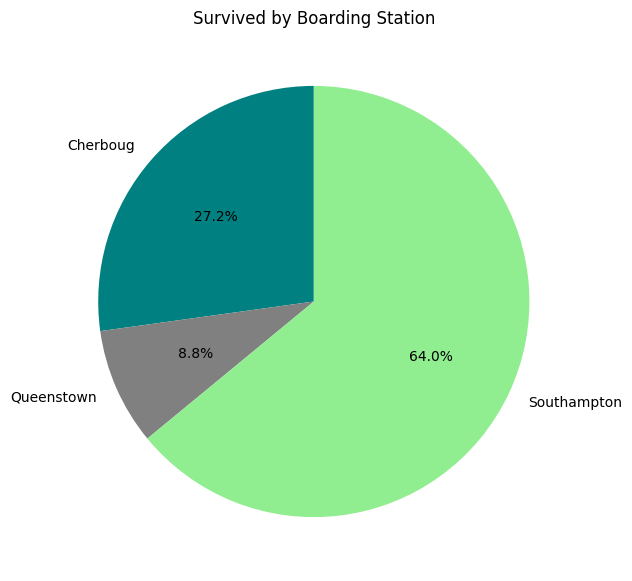

In [138]:
# Visualize survival by Boarding Station(Embarked column) 
survival_rate_by_embarked = survived_passengers.groupby('Embarked').size()   # group by survived passengers   

boarding_labels = ["Cherboug", "Queenstown", "Southampton"]

# Plot a pie chart
plt.figure(figsize=(7, 7))
survival_rate_by_embarked.plot(kind='pie', labels=boarding_labels, 
                               autopct='%1.1f%%', 
                               colors=['teal', 'grey', 'lightgreen'], startangle=90, legend=False)

# Add title
plt.title('Survived by Boarding Station')

plt.show()          # Show plot


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

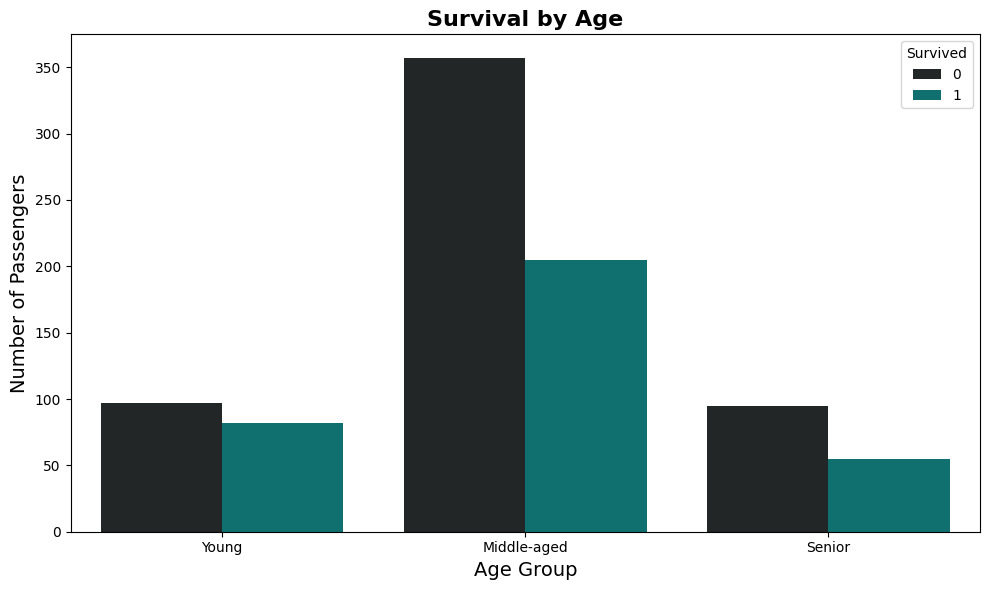

In [139]:
# Visualize survival by age group
# define bins and labels for different age ranges
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 20, 40, 80], labels=['Young', 'Middle-aged', 'Senior'])

# Plot a count plot
plt.figure(figsize=(10, 6))
sns.countplot(x='Age_Group', hue='Survived', data=df, color="teal")

# Add title and labels
plt.title('Survival by Age', fontsize=16, weight='bold')
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Number of Passengers', fontsize=14)

plt.tight_layout()          # Show plot
plt.show()


###Encoding non numerical values

In [140]:
#label encoding for columns with 2 counts(survived)
le = LabelEncoder()

unique_counts = df.nunique()            #df.unique() count the number of unique counts in a df column

columns_to_encode = unique_counts[unique_counts<=2].index.to_list()

for col in columns_to_encode:
    df[col] = le.fit_transform(df[col])

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_Group
0,0,3,1,22.0,1,0,7.2500,S,Middle-aged
1,1,1,0,38.0,1,0,71.2833,C,Middle-aged
2,1,3,0,26.0,0,0,7.9250,S,Middle-aged
3,1,1,0,35.0,1,0,53.1000,S,Middle-aged
4,0,3,1,35.0,0,0,8.0500,S,Middle-aged


In [141]:
#get.dummies() on columns with more than 2 unique counts
df =pd.get_dummies(df, drop_first=True, dtype=float)

df.head()

<IPython.core.display.Javascript object>

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S,Age_Group_Middle-aged,Age_Group_Senior
0,0,3,1,22.0,1,0,7.2500,0.0,1.0,1.0,0.0
1,1,1,0,38.0,1,0,71.2833,0.0,0.0,1.0,0.0
2,1,3,0,26.0,0,0,7.9250,0.0,1.0,1.0,0.0
3,1,1,0,35.0,1,0,53.1000,0.0,1.0,1.0,0.0
4,0,3,1,35.0,0,0,8.0500,0.0,1.0,1.0,0.0


##Feature selection

A. Chi-Square Test with alpha = 0.05

H0: there is no significant relationship between the features (sex, passenger class, and embarked) and target (the survival rate)

In [142]:
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked_Q', 'Embarked_S', 'Age_Group_Middle-aged',
       'Age_Group_Senior'],
      dtype='object')

In [143]:
df.shape

(891, 11)

In [144]:
from sklearn.feature_selection import chi2
x = df[["Sex", "Pclass",'Embarked_Q', 'Embarked_S']]
y = df["Survived"]

chi2_values, p_values = chi2(x, y)

print("Chi values:", chi2_values)
print("P_values:", p_values)

Chi values: [9.27024470e+01 3.08736994e+01 1.08467891e-02 5.48920482e+00]
P_values: [6.07783826e-22 2.75378563e-08 9.17051963e-01 1.91342437e-02]


From the chi square test:
The p-values< alpha for all the above features, so we reject the null hypothesis, and conclude there's a significant relationship between sex, passenger class, embarked and survival. 

We'll keep these features for the model.

B. Random Forest 

In [145]:
y = df["Survived"]
X = df.drop(columns=["Survived"], axis=1)

In [146]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split the data into 2 sets. 80% for training and 20% for testing
#where X= features, y= target variable, and test_size= 0.2 means 20% is for testing, and 80% is for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier()
model.fit(X_train, y_train)

feature_importances = model.feature_importances_
features = X.columns

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)



<IPython.core.display.Javascript object>

                 Feature  Importance
1                    Sex    0.271592
5                   Fare    0.265465
2                    Age    0.221623
0                 Pclass    0.092474
3                  SibSp    0.053142
4                  Parch    0.037286
7             Embarked_S    0.025158
8  Age_Group_Middle-aged    0.016713
6             Embarked_Q    0.009848
9       Age_Group_Senior    0.006700


From the Random Forest Classifier:
1. Sex, fare, age, passenger class, sibling-spouse parent child features have high  feature importance, so they have a significant relationship with the target variable. 
2. Ticket features don't have any significance in predicting the target variable.
3. Since sibling-spouse and parent-child features are correlated, let's feature engineer it into family size

Feature Engineering Sibling-Spouse(SibSp) and Parent-Child(ParCh) columns

In [147]:
# Create family size. Combine SibSp (siblings/spouses) and Parch (parents/children) features
df['family_size'] = df['SibSp'] + df['Parch']

# Define a function to calculate family size
def calculate_family_size(row):
    return row['SibSp'] + row['Parch']

# Apply the function to calculate family size
df['Family Size'] = df.apply(calculate_family_size, axis=1)

# Create bins for family size
family_size_bins = [0, 1, 3, 5, 10]                         # Define bin edges for family size
family_size_labels = ['Alone', 'Small', 'Medium', 'Large']  # Labels for each category

# Create a new column 'family group' using pd.cut to bin family sizes into categories
df['Family Group'] = pd.cut(df['Family Size'], bins=family_size_bins, labels=family_size_labels, right=False)

# View the resulting DataFrame
print(df[['SibSp', 'Parch', 'Family Size', 'Family Group']].head())


<IPython.core.display.Javascript object>

   SibSp  Parch  Family Size Family Group
0      1      0          1.0        Small
1      1      0          1.0        Small
2      0      0          0.0        Alone
3      1      0          1.0        Small
4      0      0          0.0        Alone


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

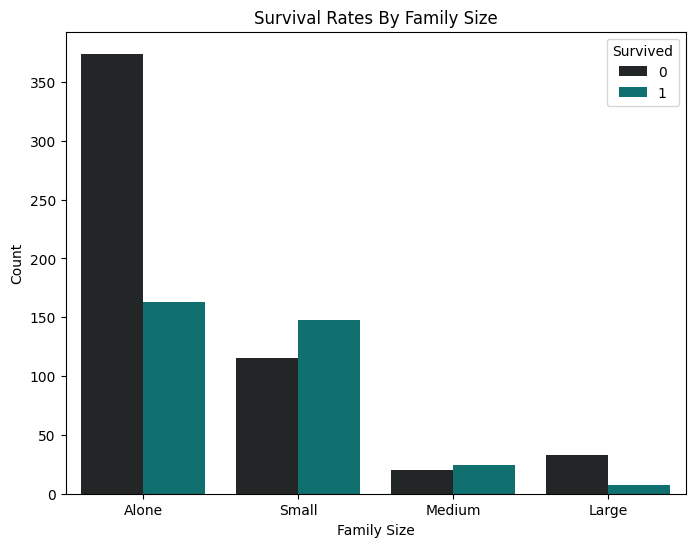

In [148]:
# Plot a barplot of survival by family groups
plt.figure(figsize=(8, 6))
sns.countplot(x='Family Group', hue= "Survived", data=df, color='teal')

# Add labels and title
plt.title('Survival Rates By Family Size')
plt.xlabel('Family Size')
plt.ylabel('Count')

plt.show()          # Show plot

##Fit Model

In [ ]:
# Split the data step. Splitting already done in the random forest feature selection
#  AKA the Holdout Method Cross Validation

In [150]:
# Standardize the Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<IPython.core.display.Javascript object>

In [151]:
# perform SMOTE(Synthetic Minority Over-Sampling Technique) on train data before fitting the model
# works by generating synthetic samples for the minority class to balance distribution to provide a more balanced set for better modelling

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Original data set:", y_train.shape[0])
print("Resampled data set:", y_resampled.shape[0])

Original data set: 712
Resampled data set: 888


In [152]:
#check if class balancing worked
y_resampled.value_counts()

Survived
0    444
1    444
Name: count, dtype: int64

A. Logistic Regression

In [153]:
# Initialize Logistic Regression model
logistic_model = LogisticRegression()

# train the model
logistic_model.fit(X_train, y_train)

LogisticRegression()

In [154]:
# 4. Make predictions
y_pred_logistic = logistic_model.predict(X_test)

In [155]:
accuracy = accuracy_score(y_test, y_pred_logistic)
conf_matrix = confusion_matrix(y_test, y_pred_logistic)
class_report = classification_report(y_test, y_pred_logistic)

# Output the evaluation results
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.7989
Confusion Matrix:
[[90 15]
 [21 53]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       105
           1       0.78      0.72      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



In [169]:
#KFold Crossvalidation(CV)

# initialize kfold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# perform KFold CV
accuracies = []             # store accuracy scores for each fold
for train_index, test_index in skf.split(X, y):
    # Split data into training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Train the model
logistic_model.fit(X_train, y_train)

# Make predictions
y_pred = logistic_model.predict(X_test)

# Calculate accuracy for this fold
accuracy = accuracy_score(y_test, y_pred)
accuracies.append(accuracy)

# Print out accuracy scores for each fold
print(f"Accuracy scores for each fold: {accuracies}")

# Print the average accuracy across all folds
print(f"Average accuracy: {sum(accuracies)/len(accuracies)}")

Accuracy scores for each fold: [0.8089887640449438]
Average accuracy: 0.8089887640449438


In [157]:
# Perform cross-validation and get predictions
cross_val = cross_val_predict(logistic_model, X, y, cv=10)
# Evaluate the model
cross_accuracy = cross_val_score(logistic_model, X, y, cv=10, scoring='accuracy')
print("Accuracy: ", cross_accuracy)
print("Mean Accuracy: ", cross_accuracy.mean())


Accuracy:  [0.77777778 0.78651685 0.75280899 0.80898876 0.80898876 0.76404494
 0.78651685 0.7752809  0.80898876 0.84269663]
Mean Accuracy:  0.7912609238451935


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

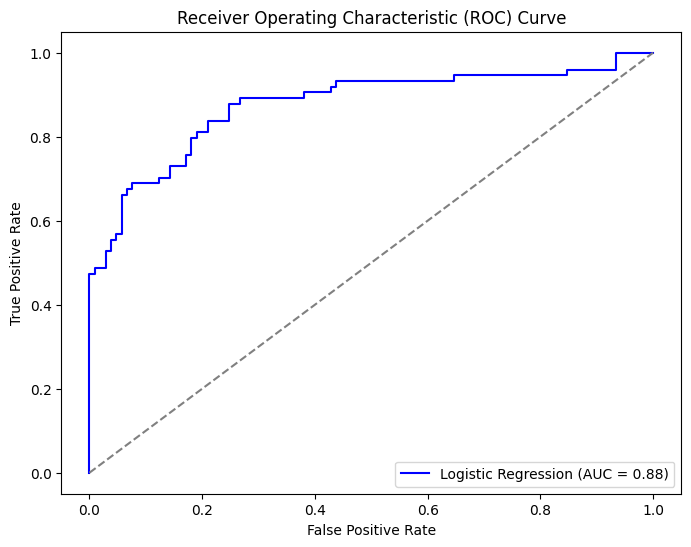

In [158]:
# Predict probabilities
y_prob_rf = logistic_model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
roc_auc = auc(fpr, tpr)

#  Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

B. Decision Tree

In [159]:
# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier()

# Train Decision Tree Classifier
clf.fit(X_train, y_train)


DecisionTreeClassifier()

In [160]:
# make prediction
y_pred_dt = clf.predict(X_test)

In [161]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_dt)
conf_matrix = confusion_matrix(y_test, y_pred_dt)
class_report = classification_report(y_test, y_pred_dt)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.7821229050279329
Confusion Matrix:
[[85 20]
 [19 55]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       105
           1       0.73      0.74      0.74        74

    accuracy                           0.78       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.78      0.78      0.78       179



In [162]:
# Perform cross-validation and get predictions
cross_val = cross_val_predict(clf, X, y, cv=10)
# Evaluate the model
cross_accuracy = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
print("Accuracy: ", cross_accuracy)
print("Mean Accuracy: ", cross_accuracy.mean())


Accuracy:  [0.75555556 0.80898876 0.71910112 0.76404494 0.83146067 0.76404494
 0.82022472 0.74157303 0.86516854 0.80898876]
Mean Accuracy:  0.7879151061173533


C. Random Forest

In [163]:
# initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# train model
rf.fit(X_train, y_train)

# make predictions
y_pred_rf = clf.predict(X_test)

In [164]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_rf)
conf_matrix = confusion_matrix(y_test, y_pred_rf)
class_report = classification_report(y_test, y_pred_rf)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.7821229050279329
Confusion Matrix:
[[85 20]
 [19 55]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       105
           1       0.73      0.74      0.74        74

    accuracy                           0.78       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.78      0.78      0.78       179



In [165]:
# Perform cross-validation and get predictions
cross_val = cross_val_predict(rf, X, y, cv=10)
# Evaluate the model
cross_accuracy = cross_val_score(rf, X, y, cv=10, scoring='accuracy')
print("Accuracy: ", cross_accuracy)
print("Mean Accuracy: ", cross_accuracy.mean())


Accuracy:  [0.75555556 0.80898876 0.75280899 0.82022472 0.88764045 0.82022472
 0.80898876 0.75280899 0.80898876 0.85393258]
Mean Accuracy:  0.8070162297128588


From the above classifiers, the logistic regression was the best because it had the highest F-1 score

In [166]:
# # Plotting the confusion matrix using seaborn heatmap
# plt.figure(figsize=(6, 5))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

Conclusion:

1. Sex was the most crucial determinant for survival. Rescuers prioritized female passengers
2. Social class (fare and passenger class) also heavily influenced survival because rescuers prioritized the elite and their cabins(first class) on the ship were closest to life boats.
3. Age influenced survival because rescue efforts prioritized younger passengers
4. Family ties influenced survival rates too since most survivors were related


Lastly, ML models are an excellent for disaster preparedness. For instance, future ships should build safety systems that ensure each passenger, regardless of gender, class, and social class, has a fair shot at survival.
 